## Preliminares

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler

from qiskit import Aer, QuantumCircuit, transpile
from qiskit.opflow import Z, I
from qiskit.utils import  algorithm_globals
from qiskit.algorithms.optimizers import SPSA

from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit.tools.visualization import plot_histogram, plot_state_city, plot_state_qsphere

from IPython.display import clear_output

from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.decomposition import PCA

algorithm_globals.random_seed = 42



from Aux_Data import plot_predicted, plot_area, plot_bloch_sphere, plot_sampled_features, get_binary_dataset
from QWNN import  quantum_weightless_neuron_ry, quantum_weightless_nn
from quantum_encoding import angle_encoding
from Aux_QuantumML import get_opflow_qnn, ttn



Experimentos com uma Rede no dataset Breast Cancer

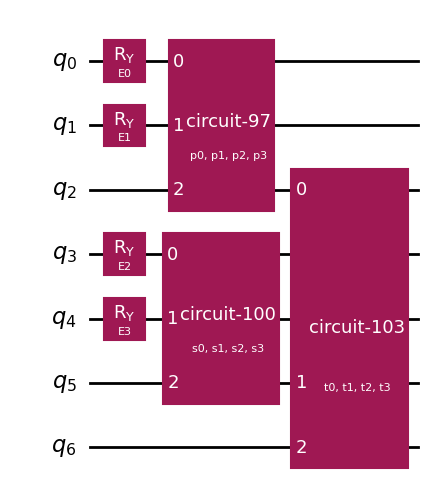

In [2]:
hamiltonian_qwnn = Z ^ I ^ I ^ I ^ I ^ I ^ I
qwnn_qc = QuantumCircuit(7)
feature_map = angle_encoding(4)
qwnn_qc.append(feature_map, [0,1,3,4])
ansatz_qwnn= quantum_weightless_nn()
qwnn_qc.append(ansatz_qwnn, [0,1,2,3,4,5,6])
qwnn_qc.decompose().draw('mpl', style='iqx')

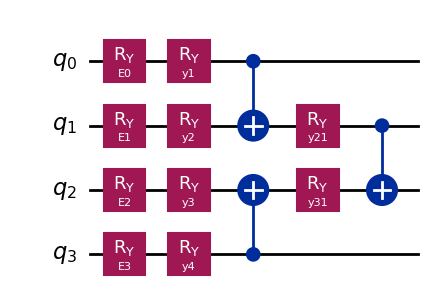

In [3]:
hamiltonian_ttn = I ^ Z ^ I ^ I 
ttn_qc = QuantumCircuit(4)
ttn_qc.append(feature_map, [0,1,2,3])
ansatz_ttn= ttn()
ttn_qc.append(ansatz_ttn, [0,1,2,3])
ttn_qc.decompose().draw('mpl', style='iqx')

In [ ]:
# callback function that draws a live plot when the .fit() method is called
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["figure.figsize"] = (6, 4)
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

    
def run_experiments(X, y, n_times, ansatz_chosen= "QWNN", apply_pca = False, pca_components = 4):
    if(ansatz_chosen=="QWNN"):
        quantum_circuit = qwnn_qc
        ansatz = ansatz_qwnn
        hamiltonian = hamiltonian_qwnn
    if(ansatz_chosen=="TTN"):
        quantum_circuit = ttn_qc
        ansatz = ansatz_ttn
        hamiltonian = hamiltonian_ttn
    normalization = np.pi
    score_list = []
    if(apply_pca): pca = PCA(pca_components)
    for i in range(n_times):
        print("iteracao :", i)
        #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=algorithm_globals.random_seed, stratify=y)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y)
        if(apply_pca):
            X_train_new = pca.fit_transform(X_train)
            X_test_new = pca.transform(X_test)
        else:
            X_train_new, X_test_new = X_train, X_test
        minmax_scale = MinMaxScaler((0, normalization)).fit(X_train_new)
        X_train_new = minmax_scale.transform(X_train_new)
        X_test_new = minmax_scale.transform(X_test_new)
        qnn = get_opflow_qnn(quantum_circuit, feature_map, ansatz, hamiltonian)
        clf = NeuralNetworkClassifier(qnn, optimizer = SPSA())
        clf.fit(X_train_new, y_train)
        score = clf.score(X_test_new, y_test)
        score_list.append(score)
        print("score: ", score)
    print("Mean: ", np.mean(score_list))
    print("Std: ", np.std(score_list))
    print(score_list)
    return score_list

## Base de dados selecionada:

In [3]:
class_a = 0
class_b = 1
# Loading some example data
breast_cancer = datasets.load_breast_cancer()
X_all = breast_cancer.data[:, :]
Y_all = breast_cancer.target
X, y = get_binary_dataset(X_all, Y_all, class_a, class_b)


In [4]:
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X)

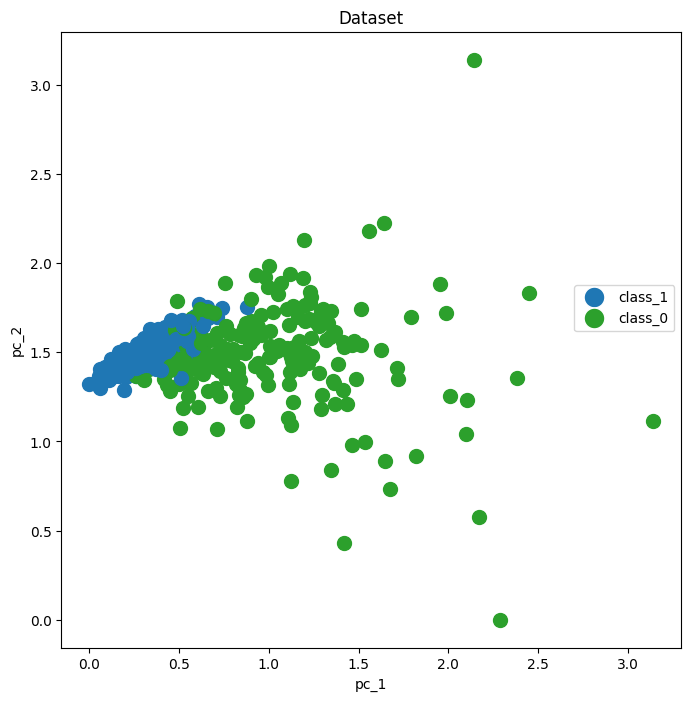

In [5]:
normalization = np.pi
minmax_scale = MinMaxScaler((0, normalization)).fit(X_pca)
X_pca = minmax_scale.transform(X_pca)
plot_sampled_features(X_pca[:, [0,1]], y, axis_x_name='pc_1', axis_y_name='pc_2', class_name_minus="class_0", class_name_plus="class_1")

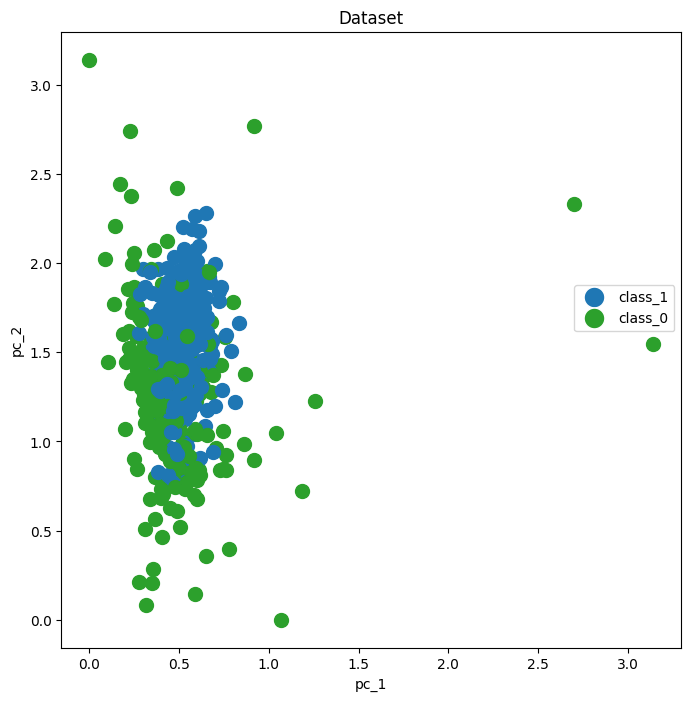

In [9]:
plot_sampled_features(X_pca[:, [2,3]], y, axis_x_name='pc_1', axis_y_name='pc_2', class_name_minus="class_0", class_name_plus="class_1")

## QWNN

 Rodando uma única vez

In [ ]:
class_a = 0
class_b = 1
# Loading some example data
breast_cancer = datasets.load_breast_cancer()
X_all = breast_cancer.data[:, :]
Y_all = breast_cancer.target
X, y = get_binary_dataset(X_all, Y_all, class_a, class_b)

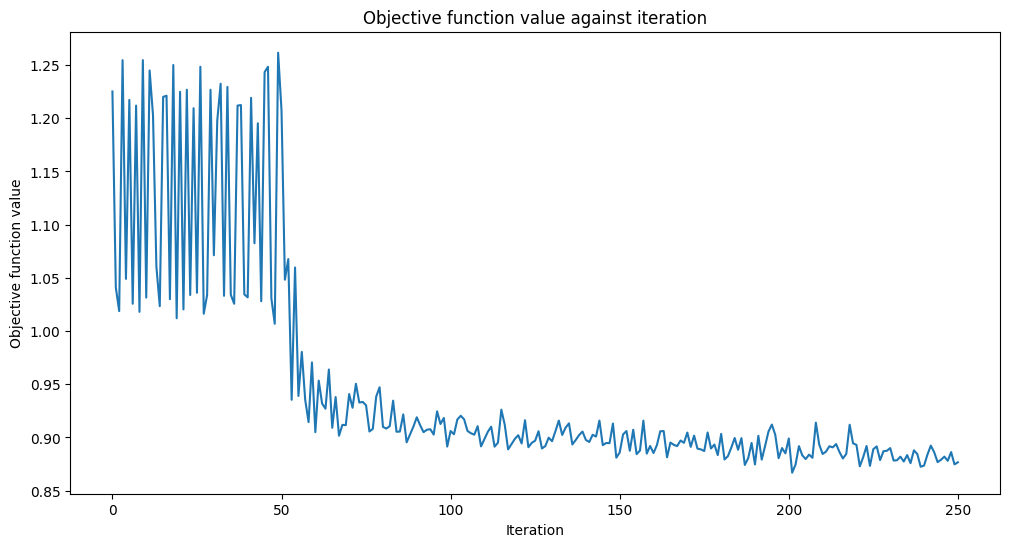

0.6403508771929824

In [5]:
hamiltonian = Z ^ I ^ I ^ I ^ I ^ I ^ I
qnn = get_opflow_qnn(qwnn_circuit, feature_map, ansatz, hamiltonian)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y)
pca = PCA(n_components=4)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
normalization = np.pi
minmax_scale = MinMaxScaler((0, normalization)).fit(X_train_pca)
X_train_pca = minmax_scale.transform(X_train_pca)
X_test_pca = minmax_scale.transform(X_test_pca)
opflow_classifier = NeuralNetworkClassifier(qnn, optimizer = SPSA(), callback=callback_graph)
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
opflow_classifier.fit(X_train_pca, y_train)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
opflow_classifier.score(X_test_pca, y_test)

 Rodando várias vezes

In [4]:
class_a = 0
class_b = 1
# Loading some example data
wine = datasets.load_wine()
X_all = wine.data[:, :]
Y_all = wine.target
X, y = get_binary_dataset(X_all, Y_all, class_a, class_b)

In [17]:
score_list = []
best_score = 0
hamiltonian = Z ^ I ^ I ^ I ^ I ^ I ^ I
qnn = get_opflow_qnn(qwnn_circuit, feature_map, ansatz, hamiltonian)
best_clf = NeuralNetworkClassifier(qnn, optimizer = SPSA())
pca = PCA(n_components=4)
for i in range(2):
    print("iteracao :", i)
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=algorithm_globals.random_seed, stratify=y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    normalization = np.pi
    minmax_scale = MinMaxScaler((0, normalization)).fit(X_train_pca)
    X_train_pca = minmax_scale.transform(X_train_pca)
    X_test_pca = minmax_scale.transform(X_test_pca)
    qnn = get_opflow_qnn(qwnn_circuit, feature_map, ansatz, hamiltonian)
    clf = NeuralNetworkClassifier(qnn, optimizer = SPSA())
    clf.fit(X_train_pca, y_train)
    score = clf.score(X_test_pca, y_test)
    score_list.append(score)
    
    print("score: ", score)
    if(score>best_score):
        best_score = score
        best_clf = clf
    
print("Mean: ", np.mean(score_list))
print("Std: ", np.std(score_list))
print(best_score)
print(score_list)

iteracao : 0


In [9]:
print(score_list)

[0.9230769230769231, 0.9615384615384616, 0.9615384615384616, 0.8076923076923077, 0.8846153846153846]


# TTN

In [6]:
class_a = 0
class_b = 1
# Loading some example data
breast_cancer = datasets.load_breast_cancer()
X_all = breast_cancer.data[:, :]
Y_all = breast_cancer.target
X, y = get_binary_dataset(X_all, Y_all, class_a, class_b)

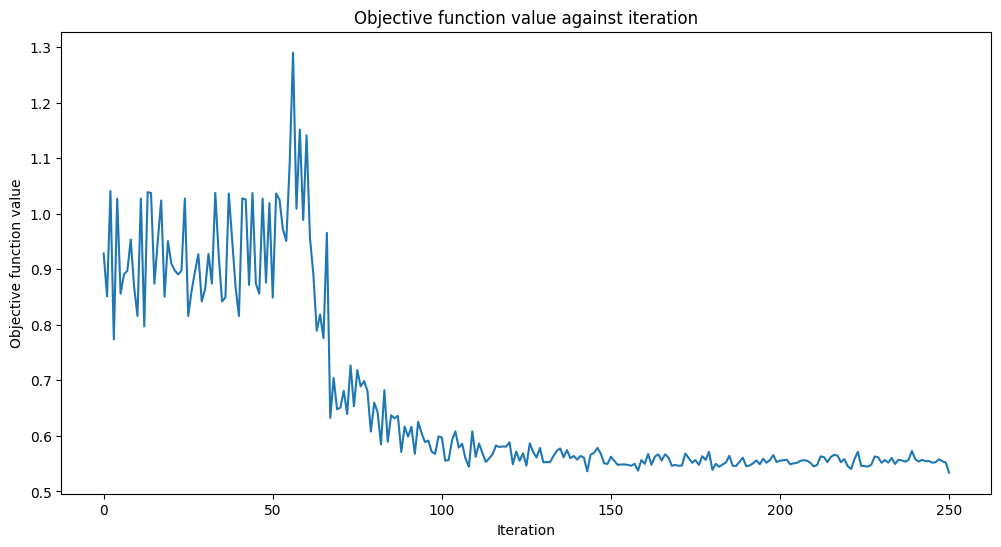

0.8421052631578947

In [8]:
hamiltonian = I ^ Z ^ I ^ I 
qnn = get_opflow_qnn(qwnn_circuit, feature_map, ansatz, hamiltonian)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=algorithm_globals.random_seed, stratify=y)
pca = PCA(n_components=4)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
normalization = np.pi
minmax_scale = MinMaxScaler((0, normalization)).fit(X_train_pca)
X_train_pca = minmax_scale.transform(X_train_pca)
X_test_pca = minmax_scale.transform(X_test_pca)
opflow_classifier = NeuralNetworkClassifier(qnn, optimizer = SPSA(), callback=callback_graph)
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
opflow_classifier.fit(X_train_pca, y_train)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
opflow_classifier.score(X_test_pca, y_test)

In [10]:
score_list = []
best_score = 0
hamiltonian = I ^ Z ^ I ^ I
qnn = get_opflow_qnn(qwnn_circuit, feature_map, ansatz, hamiltonian)
best_clf = NeuralNetworkClassifier(qnn, optimizer = SPSA())
pca = PCA(n_components=4)
for i in range(1):
    print("iteracao :", i)
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=algorithm_globals.random_seed, stratify=y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    normalization = np.pi
    minmax_scale = MinMaxScaler((0, normalization)).fit(X_train_pca)
    X_train_pca = minmax_scale.transform(X_train_pca)
    X_test_pca = minmax_scale.transform(X_test_pca)
    qnn = get_opflow_qnn(qwnn_circuit, feature_map, ansatz, hamiltonian)
    clf = NeuralNetworkClassifier(qnn, optimizer = SPSA())
    clf.fit(X_train_pca, y_train)
    score = clf.score(X_test_pca, y_test)
    score_list.append(score)
    
    print("score: ", score)
    if(score>best_score):
        best_score = score
        best_clf = clf
    
print("Mean: ", np.mean(score_list))
print("Std: ", np.std(score_list))
print(best_score)
print(score_list)

iteracao : 0
score:  0.8508771929824561
Mean:  0.8508771929824561
Std:  0.0
0.8508771929824561
[0.8508771929824561]
